# Implementação de uma Rede Neural Recorrente Simples

ELMAN, J. L. Finding Structure in Time. Cognitive Science, vol. 14, no. 2, p. 179–211, Mar. 1990. DOI 10.1207/s15516709cog1402_1. Available at: http://doi.wiley.com/10.1207/s15516709cog1402_1.

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
plt.rc("figure", figsize=(10,7))
from tensorflow import keras
from keras.layers import Dense, SimpleRNN, GRU, LSTM
from keras.models import Sequential

In [2]:
dados = np.loadtxt("Dados/dados_com_ruido.csv", delimiter=',')
t = np.loadtxt("instante.csv", delimiter=',')
dados.shape

(6000, 4)

In [3]:
#### Parameters to modify #####
look_back = 2 # number of time steps used to predict
ni=4 # number of input variables
no = 4 # number of output variables
f_train = .7 # fraction of dataset used in the training stage
vs = .2 # validation split percentage

def create_dataset (training_set_scaled , look_back):
    x_train , y_train = [], []
    for i in range(look_back , len( training_set_scaled )):
        x_train.append( training_set_scaled [i - look_back:i, 0:ni +1])
        y_train.append( training_set_scaled [i, 0:no])
    return np.array(x_train), np.array(y_train)

def converter_dados(data, step):
    #(number-samples, timesteps, number-input-features)
    #data = np.append(data,np.repeat(data[-1,],step))
    X, Y = [], []
    for i in range(len(data)-step):
        d = i + step  
        X.append(data[i:d,])
        Y.append(data[d,])
    return np.array(X), np.array(Y)

sc = MinMaxScaler()
sc.fit(dados)
dados_normalizados = sc.transform(dados)

In [4]:
import pickle
pickle.dump(sc, open("modelos/RNNscaler.p", "wb"))

In [5]:
# Separando dados de teste dos dados de treino
train_size = int(len(dados_normalizados)*f_train)
test_size = len(dados_normalizados)-train_size

dados_treino = dados_normalizados[0:train_size,:]
dados_teste = dados_normalizados[train_size:,:]

x_treino, y_treino = create_dataset(dados_treino, look_back)
x_teste, y_teste = create_dataset(dados_teste, look_back)
print(x_treino.shape, y_treino.shape, train_size*vs, sep='\n')

(4198, 2, 4)
(4198, 4)
840.0


In [6]:
# Separando dados de teste dos dados de treino
train_size = int(len(dados_normalizados)*f_train)
test_size = len(dados_normalizados)-train_size

dados_treino = dados_normalizados[0:train_size,:]
dados_teste = dados_normalizados[train_size:,:]

x_treino, y_treino=converter_dados(dados_treino, look_back)
x_teste, y_teste=converter_dados(dados_teste, look_back)
print(x_treino.shape, y_treino.shape, train_size*vs, sep='\n')

(4198, 2, 4)
(4198, 4)
840.0


In [7]:
modelo = Sequential([
    SimpleRNN(units=25, input_shape=(look_back, ni),  activation="relu"),
    Dense(no)
])

modelo.compile(optimizer="adam", loss="mse")

modelo.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 25)                750       
                                                                 
 dense (Dense)               (None, 4)                 104       
                                                                 
Total params: 854
Trainable params: 854
Non-trainable params: 0
_________________________________________________________________


In [8]:
%%time
earlyStopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min')
historico = modelo.fit(x_treino, y_treino, verbose=1, epochs=100, validation_data=(x_teste, y_teste), callbacks=[earlyStopping], batch_size=16)

Epoch 1/100
263/263 [==============================] - 3s 6ms/step - loss: 0.0290 - val_loss: 0.0034
Epoch 2/100
263/263 [==============================] - 1s 4ms/step - loss: 6.9449e-04 - val_loss: 0.0021
Epoch 3/100
263/263 [==============================] - 1s 5ms/step - loss: 2.8380e-04 - val_loss: 0.0012
Epoch 4/100
263/263 [==============================] - 1s 5ms/step - loss: 1.4667e-04 - val_loss: 7.4292e-04
Epoch 5/100
263/263 [==============================] - 1s 5ms/step - loss: 9.5015e-05 - val_loss: 6.0194e-04
Epoch 6/100
263/263 [==============================] - 1s 5ms/step - loss: 7.9596e-05 - val_loss: 6.0021e-04
Epoch 7/100
263/263 [==============================] - 1s 4ms/step - loss: 7.1573e-05 - val_loss: 6.1420e-04
Epoch 8/100
263/263 [==============================] - 1s 4ms/step - loss: 6.8336e-05 - val_loss: 5.0645e-04
Epoch 9/100
263/263 [==============================] - 1s 5ms/step - loss: 6.2851e-05 - val_loss: 5.2094e-04
Epoch 10/100
263/263 [=============

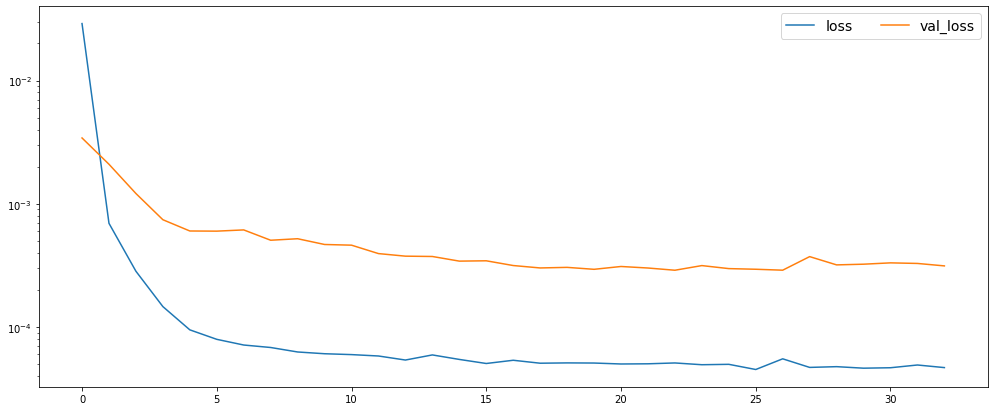

In [9]:
hist = historico.history
# plt.figure(figsize=(16,5))
pd.DataFrame(historico.history).plot(figsize=(17,7))
plt.yscale("log")
# plt.plot(hist["root_mean_squared_error"], label="Treino")
# plt.plot(hist["val_root_mean_squared_error"], label="Validação")
# plt.xlabel("Época de Treino")
# plt.ylabel("RMSE")
plt.legend(fontsize=14, ncol=2);

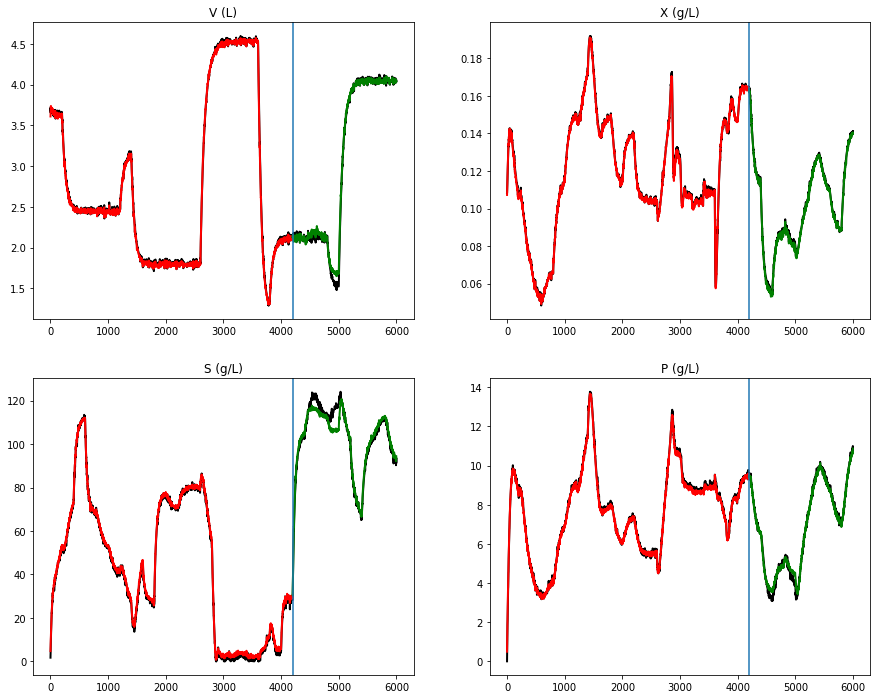

In [10]:
V_ruido = dados[:,0]
X_ruido = dados[:,1]
S_ruido = dados[:,2]
P_ruido = dados[:,3]

treino_predito = sc.inverse_transform(modelo.predict(x_treino))
teste_predito = sc.inverse_transform(modelo.predict(x_teste))

V_treino_predito = treino_predito[:,0]
X_treino_predito = treino_predito[:,1]
S_treino_predito = treino_predito[:,2]
P_treino_predito = treino_predito[:,3]

V_teste_predito = teste_predito[:,0]
X_teste_predito = teste_predito[:,1]
S_teste_predito = teste_predito[:,2]
P_teste_predito = teste_predito[:,3]

V_ruido = dados[:,0]
X_ruido = dados[:,1]
S_ruido = dados[:,2]
P_ruido = dados[:,3]

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2,figsize=(15,12))

ax1.plot(t, V_ruido, c='k', lw=2)
ax1.plot(t[0:train_size-look_back],V_treino_predito, c='r', lw=2, label='Treino')
ax1.plot(t[train_size:-look_back],V_teste_predito, c='g', lw=2, label='Teste')
ax1.set_title("V (L)", size=12)
ax1.axvline(train_size-look_back)

ax2.plot(t, X_ruido, c='k', lw=2)
ax2.set_title("X (g/L)", size=12)
ax2.plot(t[0:train_size-look_back],X_treino_predito, c='r', lw=2)
ax2.plot(t[train_size:-look_back],X_teste_predito, c='g', lw=2)
ax2.axvline(train_size-look_back)

ax3.plot(t, S_ruido, c='k', lw=2)
ax3.set_title("S (g/L)", size=12)
ax3.plot(t[0:train_size-look_back],S_treino_predito, c='r', lw=2)
ax3.plot(t[train_size:-look_back],S_teste_predito, c='g', lw=2)
ax3.axvline(train_size-look_back)

ax4.plot(t, P_ruido, c='k', lw=2)
ax4.set_title("P (g/L)", size=12)
ax4.plot(t[0:train_size-look_back],P_treino_predito, c='r', lw=2)
ax4.plot(t[train_size:-look_back],P_teste_predito, c='g', lw=2)
ax4.axvline(train_size-look_back)

plt.savefig("Imagens/predicoesSRN.pdf", format='pdf')

In [11]:
modelo.evaluate(x_treino, y_treino)
modelo.evaluate(x_teste, y_teste);

57/57 [==============================] - 0s 2ms/step - loss: 3.1367e-04


In [12]:
modelo.save("modelos/RNN")

INFO:tensorflow:Assets written to: modelos/RNN\assets
